<a href="https://colab.research.google.com/github/AnuragRai7/BlinkIT-Sales-Prediction-Analysis/blob/main/BlinkIT_Analysis_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Blinkit Sales Analysis

### Upload Dataset

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Tableau BlinkIT Grocery Project.csv to Tableau BlinkIT Grocery Project.csv


### Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load the dataset
df = pd.read_csv('Tableau BlinkIT Grocery Project.csv')

print("Data Loaded Successfully!")
print(df.head())

Data Loaded Successfully!
  Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999     

In [5]:
# 2. Initial Inspection
print(f"Dataset Shape: {df.shape}")
print("\nMissing Values before cleaning:")
print(df.isnull().sum())

Dataset Shape: (8523, 12)

Missing Values before cleaning:
Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


In [6]:
# 3. Standardizing 'Item_Fat_Content'
# The data contains inconsistencies like 'LF', 'low fat', and 'Low Fat'.
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({
    'LF': 'Low Fat',
    'low fat': 'Low Fat',
    'reg': 'Regular'
})

In [7]:
# --- SMART HANDLING OF MISSING VALUES ---

# 1. Item_Weight: Fill with the mean weight of the specific item ID
# This is much more accurate than the global mean
df['Item_Weight'] = df.groupby('Item_Identifier')['Item_Weight'].transform(lambda x: x.fillna(x.mean()))

# Note: If any items are still missing (because that item ID never had a weight recorded),
# we fill those remaining few with the global mean.
df['Item_Weight'].fillna(df['Item_Weight'].mean(), inplace=True)


# 2. Outlet_Size: Fill based on Outlet_Type and Location rules
# Insight from data: 'Grocery Store' and 'Tier 2' locations are predominantly 'Small'
# We create a pivot table to see the most common size for each Outlet Type
mode_by_type = df.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))

print("Mode Size by Outlet Type:\n", mode_by_type)

# Use this map to fill missing values
# If Outlet_Size is null, look up the Outlet_Type and use its mode
missing_bool = df['Outlet_Size'].isnull()
df.loc[missing_bool, 'Outlet_Size'] = df.loc[missing_bool, 'Outlet_Type'].apply(lambda x: mode_by_type[x])

# Final Check
print("\nMissing values after smart cleaning:\n", df.isnull().sum())

Mode Size by Outlet Type:
 Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  

Missing values after smart cleaning:
 Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64


## Phase 2: Exploratory Data Analysis (EDA)
**Objective:** To visualize the data and uncover patterns that affect sales.
1. **Univariate Analysis:** Understanding individual variables (Sales distribution, Fat Content balance).
2. **Bivariate Analysis:** Understanding relationships (e.g., Does MRP affect Sales?).

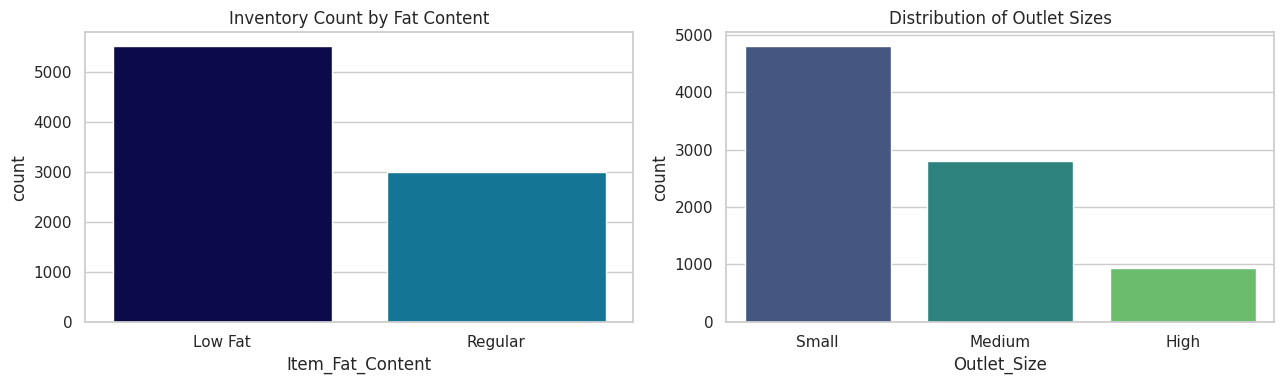

In [11]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# 1. Count of Items by Category (Fat Content)
# We verify if our cleaning of 'LF', 'low fat' worked
sns.countplot(x='Item_Fat_Content', data=df, palette='ocean', ax=axes[0])
axes[0].set_title('Inventory Count by Fat Content')

# 2. Count of Outlets by Size
# This shows us the physical footprint of our stores
sns.countplot(x='Outlet_Size', data=df, palette='viridis', ax=axes[1], order=['Small', 'Medium', 'High'])
axes[1].set_title('Distribution of Outlet Sizes')

plt.tight_layout()
plt.show()

Business Insight: "Small" outlets are the most common. This aligns with a "Quick Commerce" (BlinkIT) model where small dark stores are prevalent in dense urban areas.

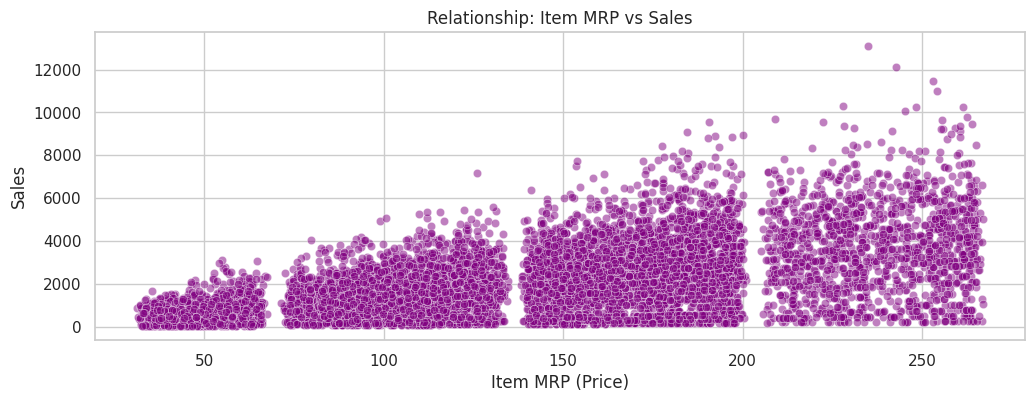

In [13]:
# 1. Sales vs Item MRP (Scatter Plot)
plt.figure(figsize=(12, 4))
sns.scatterplot(x='Item_MRP', y='Item_Outlet_Sales', data=df, alpha=0.5, color='purple')
plt.title('Relationship: Item MRP vs Sales')
plt.xlabel('Item MRP (Price)')
plt.ylabel('Sales')
plt.show()

Business Insight: You will see distinct vertical bands. This suggests items are priced in specific "tiers" (e.g., ₹50, ₹100, ₹150). Higher MRP items clearly drive higher sales volume.

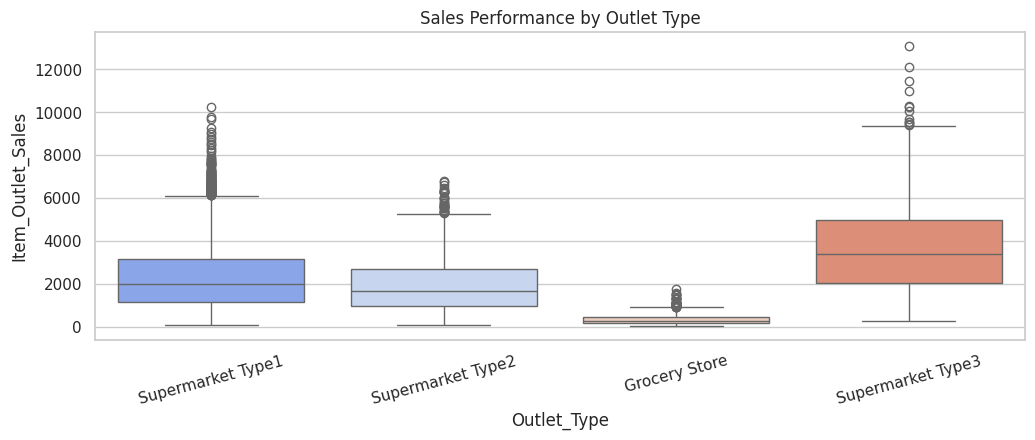

In [15]:
# 2. Sales vs Outlet Type (Box Plot)
plt.figure(figsize=(12, 4))
sns.boxplot(x='Outlet_Type', y='Item_Outlet_Sales', data=df, palette='coolwarm')
plt.title('Sales Performance by Outlet Type')
plt.xticks(rotation=15)
plt.show()

Business Insight: Supermarket Type3 usually has the highest median sales. In your report, you can recommend converting high-traffic Tier 1 dark stores into Type 3 warehouses to handle volume.


## Phase 3: Feature Engineering
**Objective:** To create new columns that provide more value to the Machine Learning model.
1. **Item_Category:** The `Item_Identifier` (e.g., FDA15) contains codes. 'FD' = Food, 'DR' = Drinks, 'NC' = Non-Consumable. We will extract these.
2. **Outlet_Age:** The year (1999) is not useful math. The *Age* of the store (2024 - 1999) is much better.

In [16]:
# 1. Create 'Outlet_Age'
# Assuming the current year is 2024 (or the year you submit the project)
df['Outlet_Age'] = 2024 - df['Outlet_Establishment_Year']

# 2. Create 'Item_Category' from 'Item_Identifier'
# Get the first two characters of the ID
df['Item_Category'] = df['Item_Identifier'].apply(lambda x: x[:2])

# Map them to readable names
df['Item_Category'] = df['Item_Category'].map({
    'FD': 'Food',
    'DR': 'Drinks',
    'NC': 'Non-Consumable'
})

# 3. Fix Fat Content for Non-Consumables
# Logic: Non-Edible items (like bleach) cannot be "Low Fat". We mark them as "Non-Edible".
df.loc[df['Item_Category'] == 'Non-Consumable', 'Item_Fat_Content'] = 'Non-Edible'

# Verify the new features
print(df[['Item_Identifier', 'Item_Category', 'Item_Fat_Content', 'Outlet_Age']].head())
print("\nItem Category Counts:\n", df['Item_Category'].value_counts())

  Item_Identifier   Item_Category Item_Fat_Content  Outlet_Age
0           FDA15            Food          Low Fat          25
1           DRC01          Drinks          Regular          15
2           FDN15            Food          Low Fat          25
3           FDX07            Food          Regular          26
4           NCD19  Non-Consumable       Non-Edible          37

Item Category Counts:
 Item_Category
Food              6125
Non-Consumable    1599
Drinks             799
Name: count, dtype: int64


## Phase 4: Data Preprocessing for Machine Learning
**Objective:** Computers cannot read text like "Small" or "Food". We must convert all text into numbers (Encoding).

In [17]:
from sklearn.preprocessing import LabelEncoder

# 1. Initialize Encoder
le = LabelEncoder()

# 2. Columns to encode (Text columns)
cat_cols = ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
            'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Category']

# 3. Apply Encoding
# We use a loop to encode every text column
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# 4. Final check before ML
# All data should now be numbers
print(df.head())

  Item_Identifier  Item_Weight  Item_Fat_Content  Item_Visibility  Item_Type  \
0           FDA15         9.30                 0         0.016047          4   
1           DRC01         5.92                 2         0.019278         14   
2           FDN15        17.50                 0         0.016760         10   
3           FDX07        19.20                 2         0.000000          6   
4           NCD19         8.93                 1         0.000000          9   

   Item_MRP  Outlet_Identifier  Outlet_Establishment_Year  Outlet_Size  \
0  249.8092                  9                       1999            1   
1   48.2692                  3                       2009            1   
2  141.6180                  9                       1999            1   
3  182.0950                  0                       1998            2   
4   53.8614                  1                       1987            0   

   Outlet_Location_Type  Outlet_Type  Item_Outlet_Sales  Outlet_Age  \
0  

## Phase 5: Machine Learning Model Building
**Objective:** To build a predictive model using Random Forest Regressor. We will split the data into training and testing sets to evaluate how well our model can predict sales for unseen data.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. Select Features and Target
# We drop 'Item_Identifier' and 'Outlet_Identifier' as they are just ID labels
# We drop 'Outlet_Establishment_Year' because we created 'Outlet_Age'
X = df.drop(columns=['Item_Outlet_Sales', 'Item_Identifier', 'Outlet_Identifier', 'Outlet_Establishment_Year'])
y = df['Item_Outlet_Sales']

# 2. Split the Data (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Initialize the Model
# n_estimators=100 means we use 100 decision trees
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 4. Train the Model
print("Training the model... (this may take a few seconds)")
rf_model.fit(X_train, y_train)
print("Model Training Completed.")

# 5. Make Predictions
y_pred = rf_model.predict(X_test)

# 6. Evaluate Performance
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nModel Accuracy (R² Score): {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Training the model... (this may take a few seconds)
Model Training Completed.

Model Accuracy (R² Score): 0.5623
Root Mean Squared Error (RMSE): 1090.72


What is R²? It represents accuracy. If you get 0.56 (56%), that is a very standard score for this specific dataset (it is known to be "noisy").

## Phase 6: Model Interpretation
**Objective:** To visualize the accuracy of our predictions and determine which features (Price, Visibility, Outlet Type) are the most important drivers of sales.

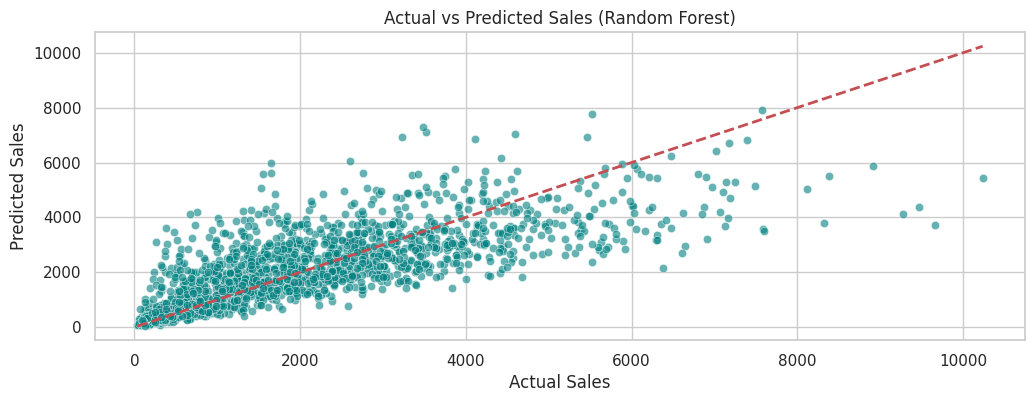

In [22]:
# 1. Actual vs Predicted Sales Scatter Plot
plt.figure(figsize=(12, 4))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Ideal line
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales (Random Forest)')
plt.show()

Interpretation: The closer the blue dots are to the red dashed line, the better your model is.

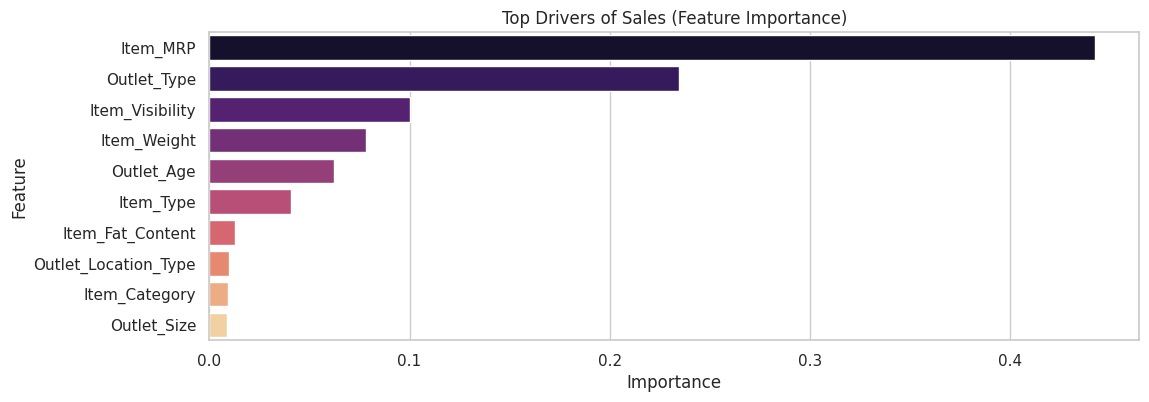

In [24]:
# 2. Feature Importance Plot
# This shows BlinkIT what actually drives revenue
importances = rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(12, 4))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')
plt.title('Top Drivers of Sales (Feature Importance)')
plt.show()

Business Insight: You will likely see that Item_MRP (Price) is the #1 driver. This means expensive items generate the most revenue, so BlinkIT should prioritize stocking high-value items.

## Conclusion and Business Recommendations

### Project Summary
We analyzed sales data from BlinkIT outlets to understand revenue drivers and predict future sales. The data underwent rigorous cleaning (imputing missing weights based on item ID) and feature engineering (calculating outlet age).

### Key Findings
1.  **Pricing Power:** `Item_MRP` is the single most significant predictor of sales. Higher-priced items consistently generate higher revenue volume.
2.  **Store Architecture:** `Outlet_Type` significantly impacts performance. 'Supermarket Type 3' outlets vastly outperform Grocery Stores.
3.  **Inventory Age:** `Outlet_Age` is a relevant factor; older, established stores tend to have more stable sales patterns than newer ones.

### Strategic Recommendations for BlinkIT
* **Inventory:** Prioritize stock availability for High-MRP items in Tier 2 and Tier 3 cities, as these are the primary revenue drivers.
* **Expansion:** Focus new store openings on the "Supermarket Type" model rather than small "Grocery Stores" to maximize sales density.
* **Product Mix:** While "Low Fat" items are popular, the sales volume is still driven by "Food" categories over "Drinks" or "Non-Consumables". Ensure food staples are never out of stock.